In [70]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run prior.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [71]:
def print_if(msg, print_progress):
    if print_progress:
        print(msg)

def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [72]:
from copy import deepcopy

In [73]:
def run_experiment(config, ret_std=False, print_progress=False):
    """Run complete VCL experiment"""
    exponential_random_config = deepcopy(config)
    exponential_random_config.prior_type = 'exponential'
    
    # Initialize models
    vanillaNN = VanillaNN(config).to(DEVICE)
    gaussian_vclNN = VCLNN(config).to(DEVICE)
    exponential_vclNN = VCLNN(exponential_random_config).to(DEVICE)

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN, print_progress)
    gaussian_random_vcl_results, gaussian_random_vcl_results_std = run_experiment_for(gaussian_vclNN, print_progress)
    exponential_random_vcl_results, exponential_random_vcl_results_std = run_experiment_for(exponential_vclNN, print_progress)
    
    results = { 'Vanilla': vanilla_results, 'Gaussian VCL': gaussian_random_vcl_results, 'Exponential VCL': exponential_random_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 'Gaussian VCL': gaussian_random_vcl_results_std, 'Exponential VCL': exponential_random_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [74]:
def plot_results(config, results, results_std=None, export=True):
    """Plot comparison of results with optional error bars."""
    MARKER_SIZE = 8
    CAPSIZE = 4
    ELINEWIDTH = 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    x_ticks = range(1, len(config.tasks)+1)
    
    for model in results:
        mean_yval = (lambda res: np.mean(res[model], axis=0, where=(res[model] > 1e-6))) # average over non-zero metrics
        mean_scores = mean_yval(results)
        x_vals = np.arange(len(mean_scores)) + 1
        # If std info is provided, add error bars
        if results_std is not None:
            ax1.errorbar(x_vals, mean_scores, yerr=mean_yval(results_std), 
                         label=model, marker='o', 
                         markersize=MARKER_SIZE, capsize=CAPSIZE, elinewidth=ELINEWIDTH)
        else:
            ax1.plot(x_vals, mean_scores, 
                     label=model, marker='o', markersize=MARKER_SIZE)
    
    ax1.set_xticks(x_ticks)
    ax1.set_title(f"Mean {config.eval_metric}", fontsize=18)
    ax1.set_xlabel("# Tasks", fontsize=15)
    ax1.legend(fontsize=16)

    # Final score plot (no std)
    for model in results:
        final_scores = results[model][-1]
        x_vals = np.arange(len(final_scores)) + 1
        if results_std is not None:
            ax2.errorbar(x_vals, final_scores, yerr=results_std[model][-1], 
                         label=model, marker='o', 
                         markersize=MARKER_SIZE, capsize=CAPSIZE, elinewidth=ELINEWIDTH)
        else:
            ax2.plot(x_vals, final_scores, 
                     label=model, marker='o', markersize=MARKER_SIZE)

    ax2.set_xticks(x_ticks)
    ax2.set_title(f"Final {config.eval_metric}", fontsize=18)
    ax2.set_xlabel("# Tasks", fontsize=15)
    ax2.legend(fontsize=15)

    plt.tight_layout()
    if export:
        plt.savefig(plot_filepath(config))
    
    plt.show()

# Minimum required extensions

In [75]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'classification'
config.coreset_alg_name = 'random'

# Set random seeds
torch.manual_seed(777)
np.random.seed(777)

# Run experiment
split_cla_results, split_cla_results_std = run_experiment(config, ret_std=True, print_progress=True)


Training on Task 1 ...
... Finished training on Task 1

Task  1  Accuracy:                         0.9991 ± 0.0016


Training on Task 2 ...
... Finished training on Task 2

Task  1  Accuracy:                         0.9987 ± 0.0026
Task  2  Accuracy:                         0.9932 ± 0.0064


Training on Task 3 ...
... Finished training on Task 3

Task  1  Accuracy:                         0.7185 ± 0.0170
Task  2  Accuracy:                         0.9697 ± 0.0121
Task  3  Accuracy:                         0.9990 ± 0.0017


Training on Task 4 ...
... Finished training on Task 4

Task  1  Accuracy:                         0.5926 ± 0.0292
Task  2  Accuracy:                         0.9133 ± 0.0170
Task  3  Accuracy:                         0.9794 ± 0.0093
Task  4  Accuracy:                         0.9990 ± 0.0026


Training on Task 5 ...
... Finished training on Task 5

Task  1  Accuracy:                         0.6080 ± 0.0519
Task  2  Accuracy:                         0.9481 ± 0.0135
Tas

In [76]:
split_cla_results

{'Vanilla': array([[0.99913194, 0.        , 0.        , 0.        , 0.        ],
        [0.99869792, 0.99316406, 0.        , 0.        , 0.        ],
        [0.71849088, 0.96966797, 0.99902344, 0.        , 0.        ],
        [0.59257748, 0.91329297, 0.97943264, 0.99902344, 0.        ],
        [0.60796927, 0.94808985, 0.98583984, 0.99560547, 0.98892547]]),
 'Gaussian VCL': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.95542578, 0.        , 0.        , 0.        ],
        [0.99956597, 0.95253125, 0.93860757, 0.        , 0.        ],
        [0.99956597, 0.948125  , 0.94415729, 0.98359476, 0.        ],
        [0.99956597, 0.91091016, 0.95349419, 0.98830139, 0.9431523 ]]),
 'Exponential VCL': array([[0.99869792, 0.        , 0.        , 0.        , 0.        ],
        [0.99869792, 0.98921094, 0.        , 0.        , 0.        ],
        [0.99530343, 0.94374219, 0.99609375, 0.        , 0.        ],
        [0.99696181, 0.94073047, 0.96624

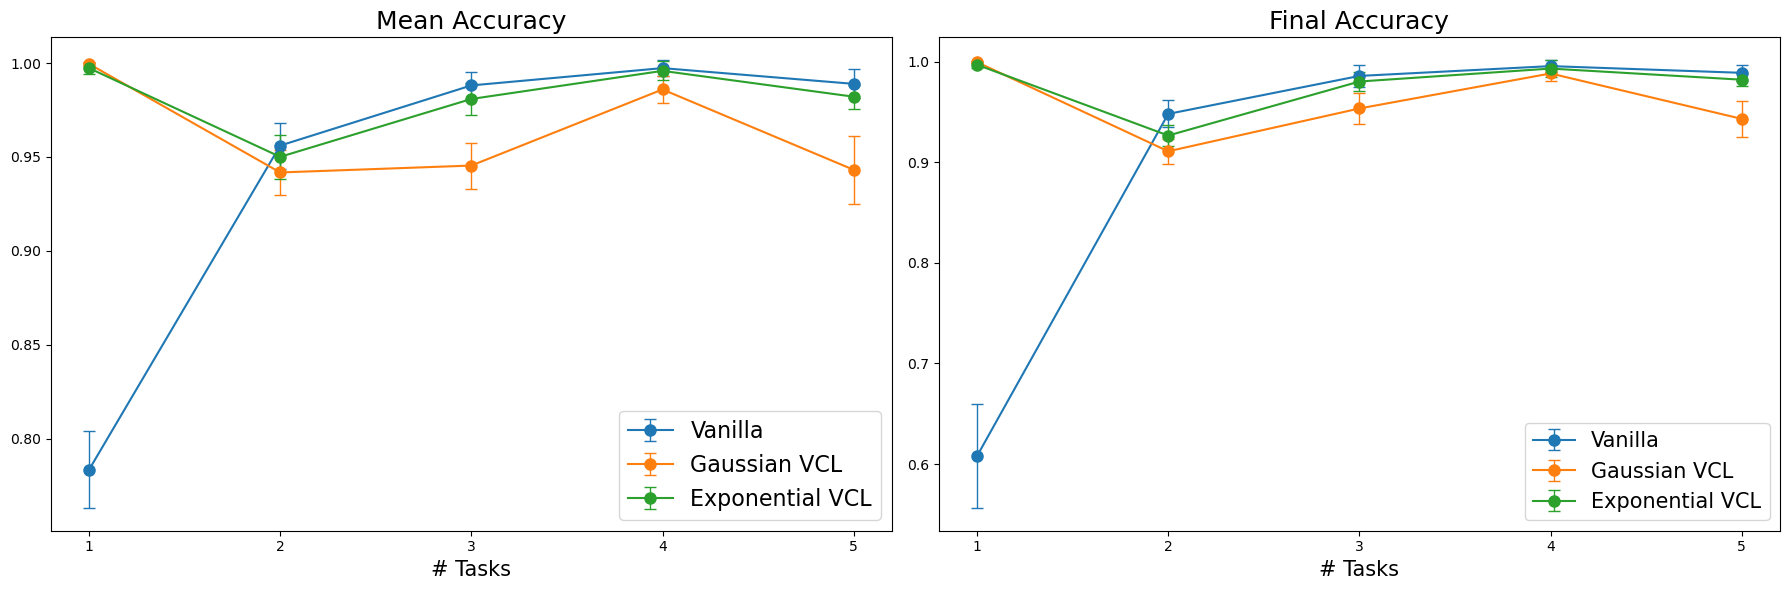

In [77]:
plot_results(config, split_cla_results, results_std=split_cla_results_std)

In [78]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'regression'
config.coreset_alg_name = 'random'
# config.init_prior_scale = 0.01

# Run experiment
split_reg_results, split_reg_results_std = run_experiment(config, ret_std=True)

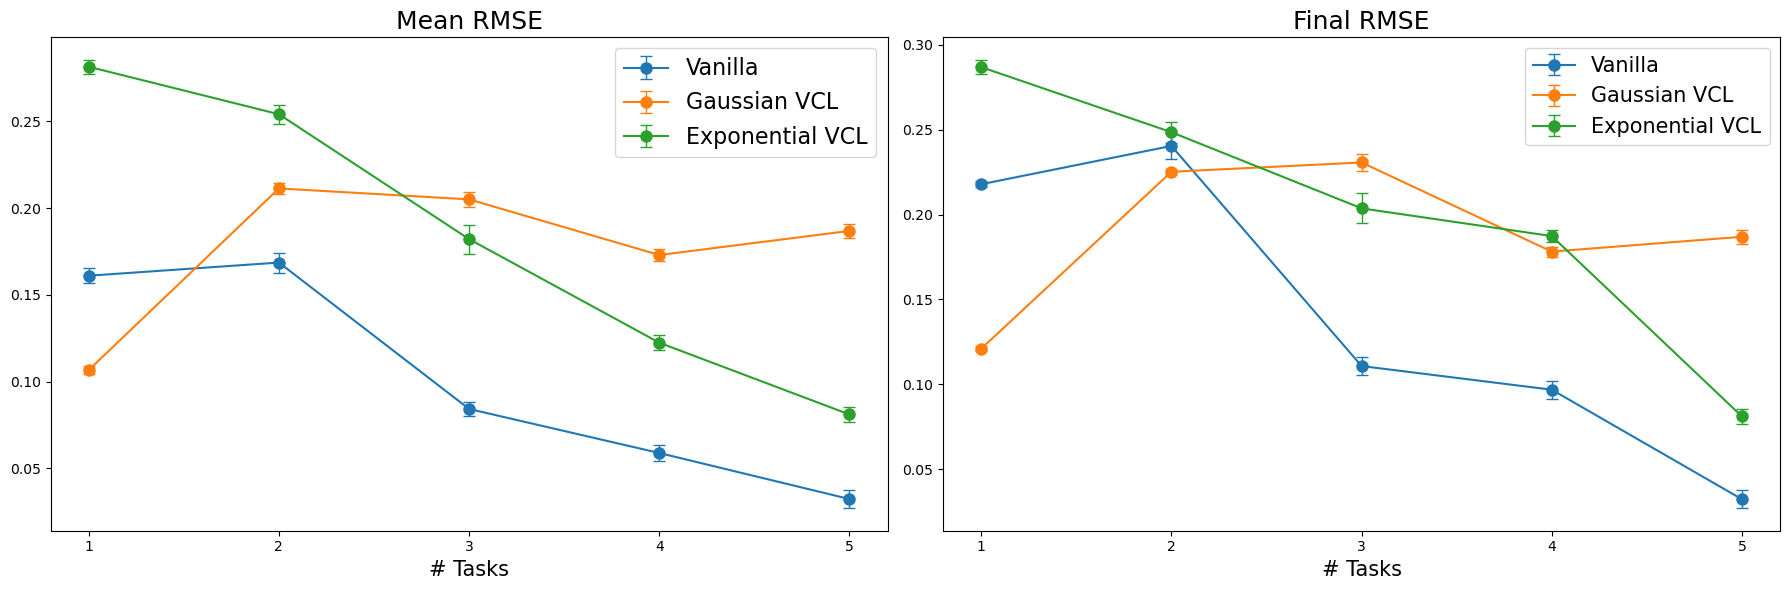

In [79]:
plot_results(config, split_reg_results, split_reg_results_std)

# Without updating prior

In [ ]:
config = ExperimentConfig()
config.task_type = 'classification'
config.coreset_alg_name = 'random'
config.update_prior = False

# Set random seeds
torch.manual_seed(777)
np.random.seed(888)

# Run experiment
noprior_cla_results, noprior_cla_results_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, noprior_cla_results, results_std=noprior_cla_results_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_alg_name = 'random'
config.update_prior = False

# Run experiment
noprior_reg_results, noprior_eg_results_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, noprior_reg_results, results_std=noprior_eg_results_std)

# Changing Coreset Size

In [ ]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'classification'
config.coreset_size = 100
config.validate()

torch.manual_seed(321)
np.random.seed(888)

# Run experiment
split_cla_results_100, split_cla_results_std_100 = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_cla_results_100, results_std=split_cla_results_std_100)

In [ ]:
config = ExperimentConfig()
config.dataset_type = 'split'
config.task_type = 'regression'
config.coreset_size = 100
config.validate()

torch.manual_seed(777)
np.random.seed(888)

# Run experiment
split_reg_results_100, split_reg_results_std_100 = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_reg_results_100, results_std=split_reg_results_std_100)

In [ ]:
plot_results(config, split_reg_results_0, results_std=split_reg_results_std_0)

# Changing Coreset Algorithm

In [ ]:
config = ExperimentConfig()
config.task_type = 'classification'
config.coreset_alg_name = 'kcenter'
config.validate()

# Run experiment
split_cla_results_kcenter, split_cla_results_kcenter_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_cla_results_kcenter, results_std=split_cla_results_kcenter_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_alg_name = 'kcenter'
config.validate()

# Run experiment
split_reg_results_kcenter, split_reg_results_kcenter_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, split_reg_results_kcenter, results_std=split_reg_results_kcenter_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_size = 0

# Run experiment
cla_results_none, cla_results_none_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, cla_results_none, results_std=cla_results_none_std)

In [ ]:
config = ExperimentConfig()
config.task_type = 'regression'
config.coreset_size = 0

# Run experiment
reg_results_none, reg_results_none_std = run_experiment(config, ret_std=True)

In [ ]:
plot_results(config, reg_results_none, results_std=reg_results_none_std)

# Compare multiple changes

In [80]:
def run_experiment_multi(task_type='classification', init_prior_scale=0.1, coreset_size=200, ret_std=True):
    """Run complete VCL experiment"""
    gaussian_none_config = ExperimentConfig(task_type=task_type,
                                            init_prior_scale=init_prior_scale,
                                            coreset_size=0)
    exponential_none_config = ExperimentConfig(task_type=task_type, 
                                               prior_type = 'exponential',
                                               init_prior_scale=init_prior_scale,
                                               coreset_size=0)
    
    gaussian_random_config = ExperimentConfig(task_type=task_type,
                                              init_prior_scale=init_prior_scale,
                                              coreset_size=coreset_size)
    exponential_random_config = ExperimentConfig(task_type=task_type, 
                                          prior_type = 'exponential',
                                          init_prior_scale=init_prior_scale,
                                          coreset_size=coreset_size)
    
    gaussian_kcenter_config = ExperimentConfig(task_type=task_type,
                                               coreset_alg_name='kcenter',
                                               init_prior_scale=init_prior_scale,
                                               coreset_size=coreset_size)
    exponential_kcenter_config = ExperimentConfig(task_type=task_type, 
                                                  prior_type = 'exponential',
                                                  coreset_alg_name='kcenter',
                                                  init_prior_scale=init_prior_scale,
                                                  coreset_size=coreset_size)
    
    
    # Initialize models
    vanillaNN = VanillaNN(gaussian_none_config).to(DEVICE)  # VanillaNN does not use coreset anyways
    gaussian_none_vclNN = VCLNN(gaussian_none_config).to(DEVICE)
    exponential_none_vclNN = VCLNN(exponential_none_config).to(DEVICE)
    gaussian_random_vclNN = VCLNN(gaussian_random_config).to(DEVICE)
    exponential_random_vclNN = VCLNN(exponential_random_config).to(DEVICE)
    gaussian_kcenter_vclNN = VCLNN(gaussian_kcenter_config).to(DEVICE)
    exponential_kcenter_vclNN = VCLNN(exponential_kcenter_config).to(DEVICE)
    

    vanilla_results, vanilla_results_std = run_experiment_for(vanillaNN)
    gaussian_none_vcl_results, gaussian_none_vcl_results_std = run_experiment_for(gaussian_none_vclNN)
    exponential_none_vcl_results, exponential_none_vcl_results_std = run_experiment_for(exponential_none_vclNN)
    gaussian_random_vcl_results, gaussian_random_vcl_results_std = run_experiment_for(gaussian_random_vclNN)
    exponential_random_vcl_results, exponential_random_vcl_results_std = run_experiment_for(exponential_random_vclNN)
    gaussian_kcenter_vcl_results, gaussian_kcenter_vcl_results_std = run_experiment_for(gaussian_kcenter_vclNN)
    exponential_kcenter_vcl_results, exponential_kcenter_vcl_results_std = run_experiment_for(exponential_kcenter_vclNN)
    
    results = { 'Vanilla': vanilla_results, 
               'Gaussian VCL (None)': gaussian_none_vcl_results, 'Exponential VCL (None)': exponential_none_vcl_results,
               'Gaussian VCL (Random)': gaussian_random_vcl_results, 'Exponential VCL (Random)': exponential_random_vcl_results,
               'Gaussian VCL (K-center)': gaussian_kcenter_vcl_results, 'Exponential VCL (K-center)': exponential_kcenter_vcl_results }
    results_std = { 'Vanilla': vanilla_results_std, 
                    'Gaussian VCL (None)': gaussian_none_vcl_results_std, 'Exponential VCL (None)': exponential_none_vcl_results_std,
                    'Gaussian VCL (Random)': gaussian_random_vcl_results_std, 'Exponential VCL (Random)': exponential_random_vcl_results_std,
                    'Gaussian VCL (K-center)': gaussian_kcenter_vcl_results_std, 'Exponential VCL (K-center)': exponential_kcenter_vcl_results_std }
    
    return results if not ret_std else (results, results_std)

In [ ]:
cla_results, cla_std = run_experiment_multi(task_type='classification')

In [ ]:
plot_results(ExperimentConfig(task_type='classification'), 
             cla_results, results_std=cla_std)

In [ ]:
reg_results, reg_std = run_experiment_multi(task_type='regression')

In [ ]:
plot_results(ExperimentConfig(task_type='regression'), 
             reg_results, results_std=reg_std)

In [ ]:
plot_results(ExperimentConfig(task_type='regression'), 
             reg_results, results_std=reg_std)

In [ ]:
small_scale_cla_results, small_scale_cla_std = run_experiment_multi(task_type='classification',
                                                                    init_prior_scale=0.01)

In [ ]:
plot_results(ExperimentConfig(task_type='classification', init_prior_scale=0.01), 
             small_scale_cla_results, results_std=small_scale_cla_std)

In [ ]:
small_scale_reg_results, small_scale_reg_std = run_experiment_multi(task_type='regression',
                                                                    init_prior_scale=0.01)

In [ ]:
plot_results(ExperimentConfig(task_type='regression', init_prior_scale=0.01), 
             small_scale_reg_results, results_std=small_scale_reg_std)

In [ ]:
small_coreset_cla_results, small_coreset_cla_std = run_experiment(task_type='classification',
                                                                  coreset_size=100)

In [ ]:
plot_results(ExperimentConfig(task_type='classification', coreset_size=100), 
             small_coreset_cla_results, results_std=small_coreset_cla_std)

In [ ]:
small_coreset_reg_results, small_coreset_reg_std = run_experiment(task_type='regression',
                                                                coreset_size=100)

In [ ]:
plot_results(ExperimentConfig(task_type='regression', coreset_size=100), 
             small_coreset_reg_results, results_std=small_coreset_reg_std)